In [20]:
import torch
from fastai.vision.all import *
import os

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

CUDA is available on this system.


In [21]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

In [22]:
def get_label_func(file_name, labels_file):
    # Load the JSON file with class labels
    with open(labels_file, "r") as f:
        labels_data = json.load(f)

    # Extract the class label based on the file name
    tl = labels_data[file_name]
    return tl["state"] + tl["pictogram"]

In [23]:
dataset_path = "/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined"

train_folder = 'train'
valid_folder = 'valid'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=lambda file_path: get_label_func(os.path.basename(file_path), dataset_path + '/labels.json'),
                   item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
                   batch_tfms=None)

dls = dblock.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)


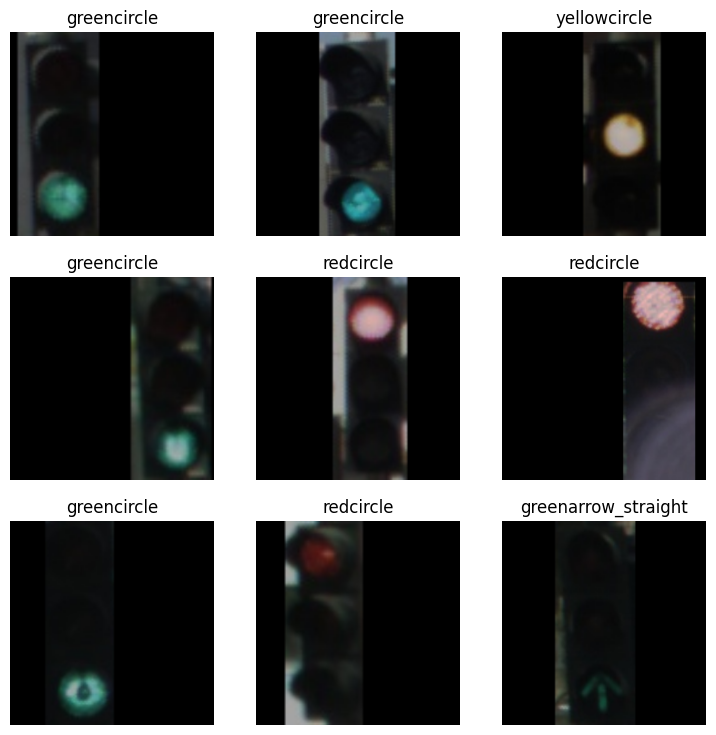

In [24]:
dls.show_batch(max_n=9)

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ippen/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.0014454397605732083)

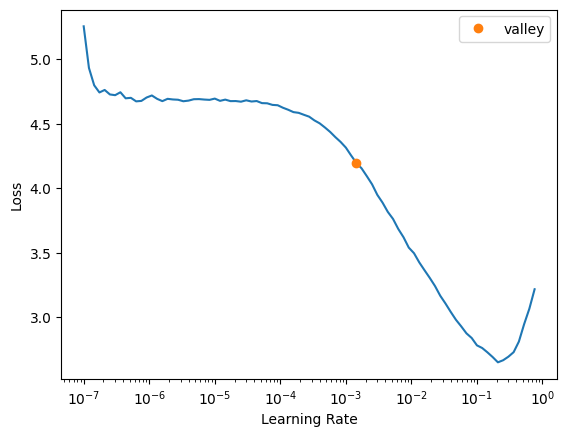

In [26]:
learn.lr_find()

In [27]:
learn.fine_tune(4, 4e-3)

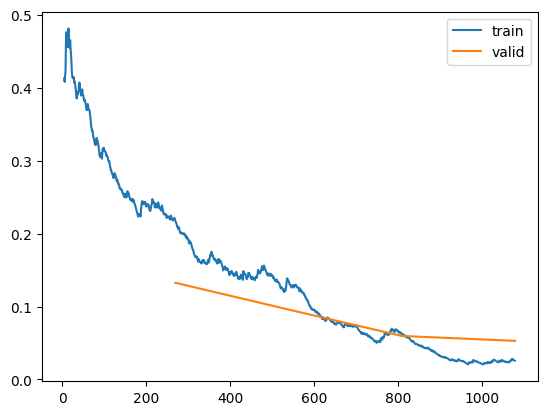

In [28]:
learn.recorder.plot_loss()

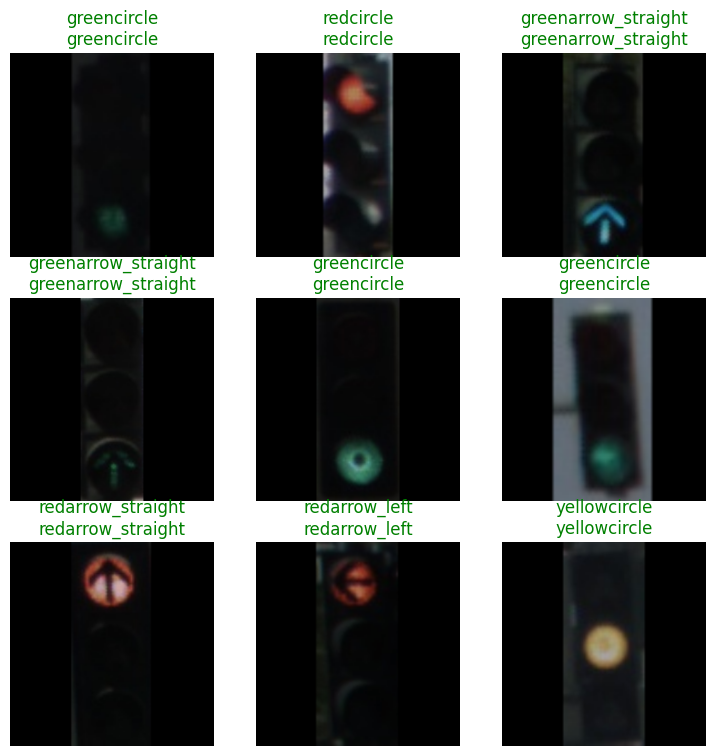

In [29]:
learn.show_results()


In [30]:
learn.save('tl_v1')

Path('/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_tl_combined/models/tl_v1.pth')

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

/home/ippen/.local/lib/python3.8/site-packages/fastai/interpret.py:131: RuntimeWarning: invalid value encountered in divide
  if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


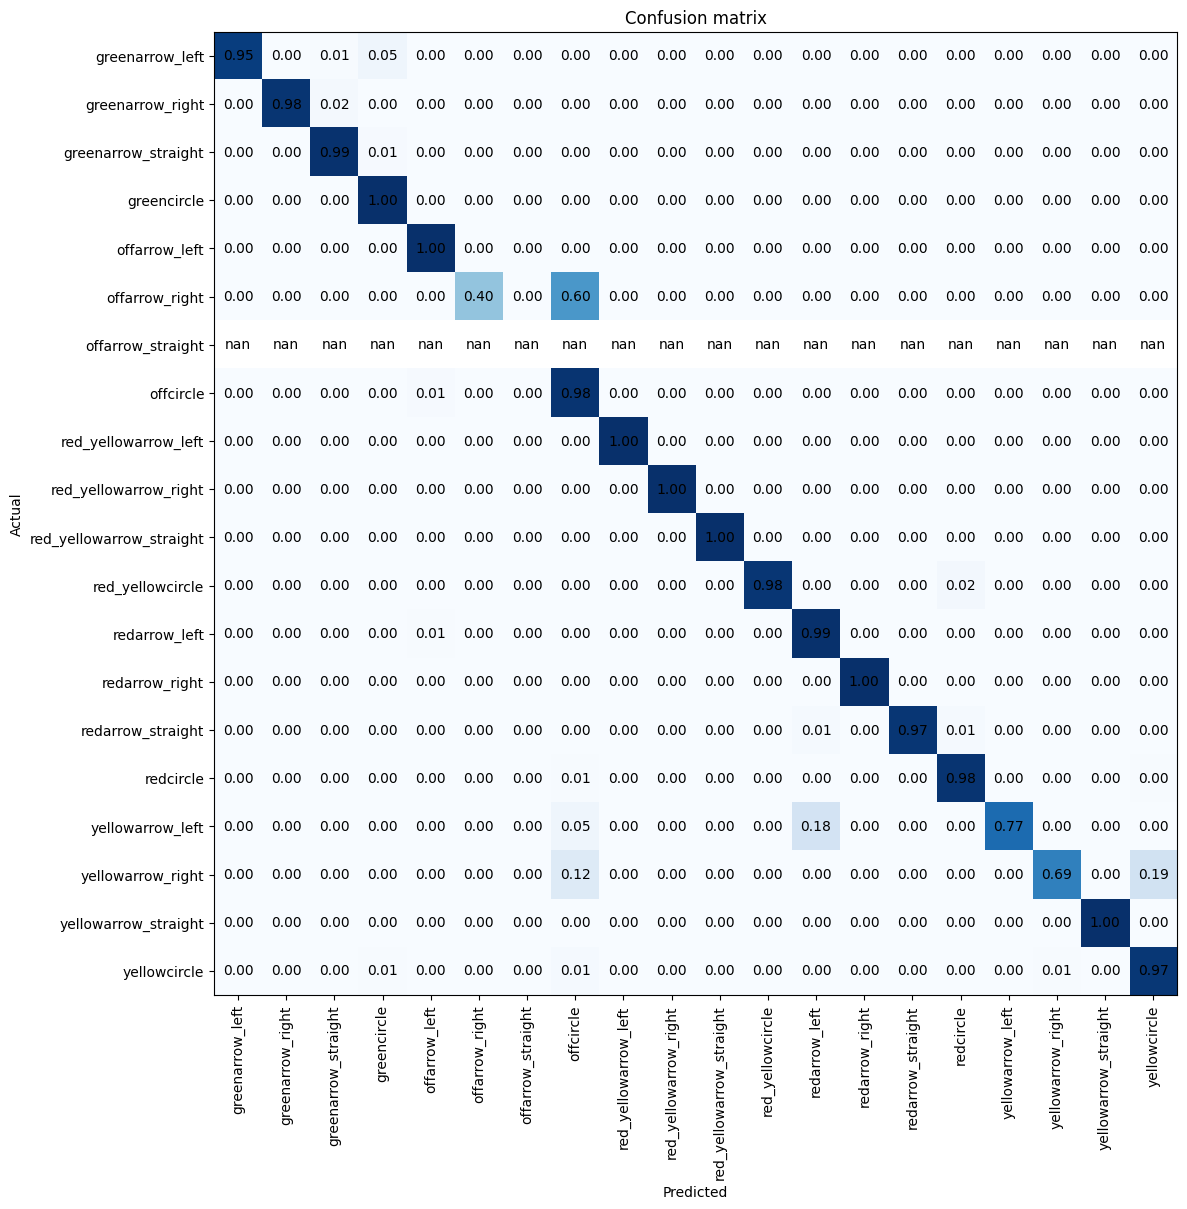

In [32]:
interp.plot_confusion_matrix(normalize=True, figsize=(12, 12))

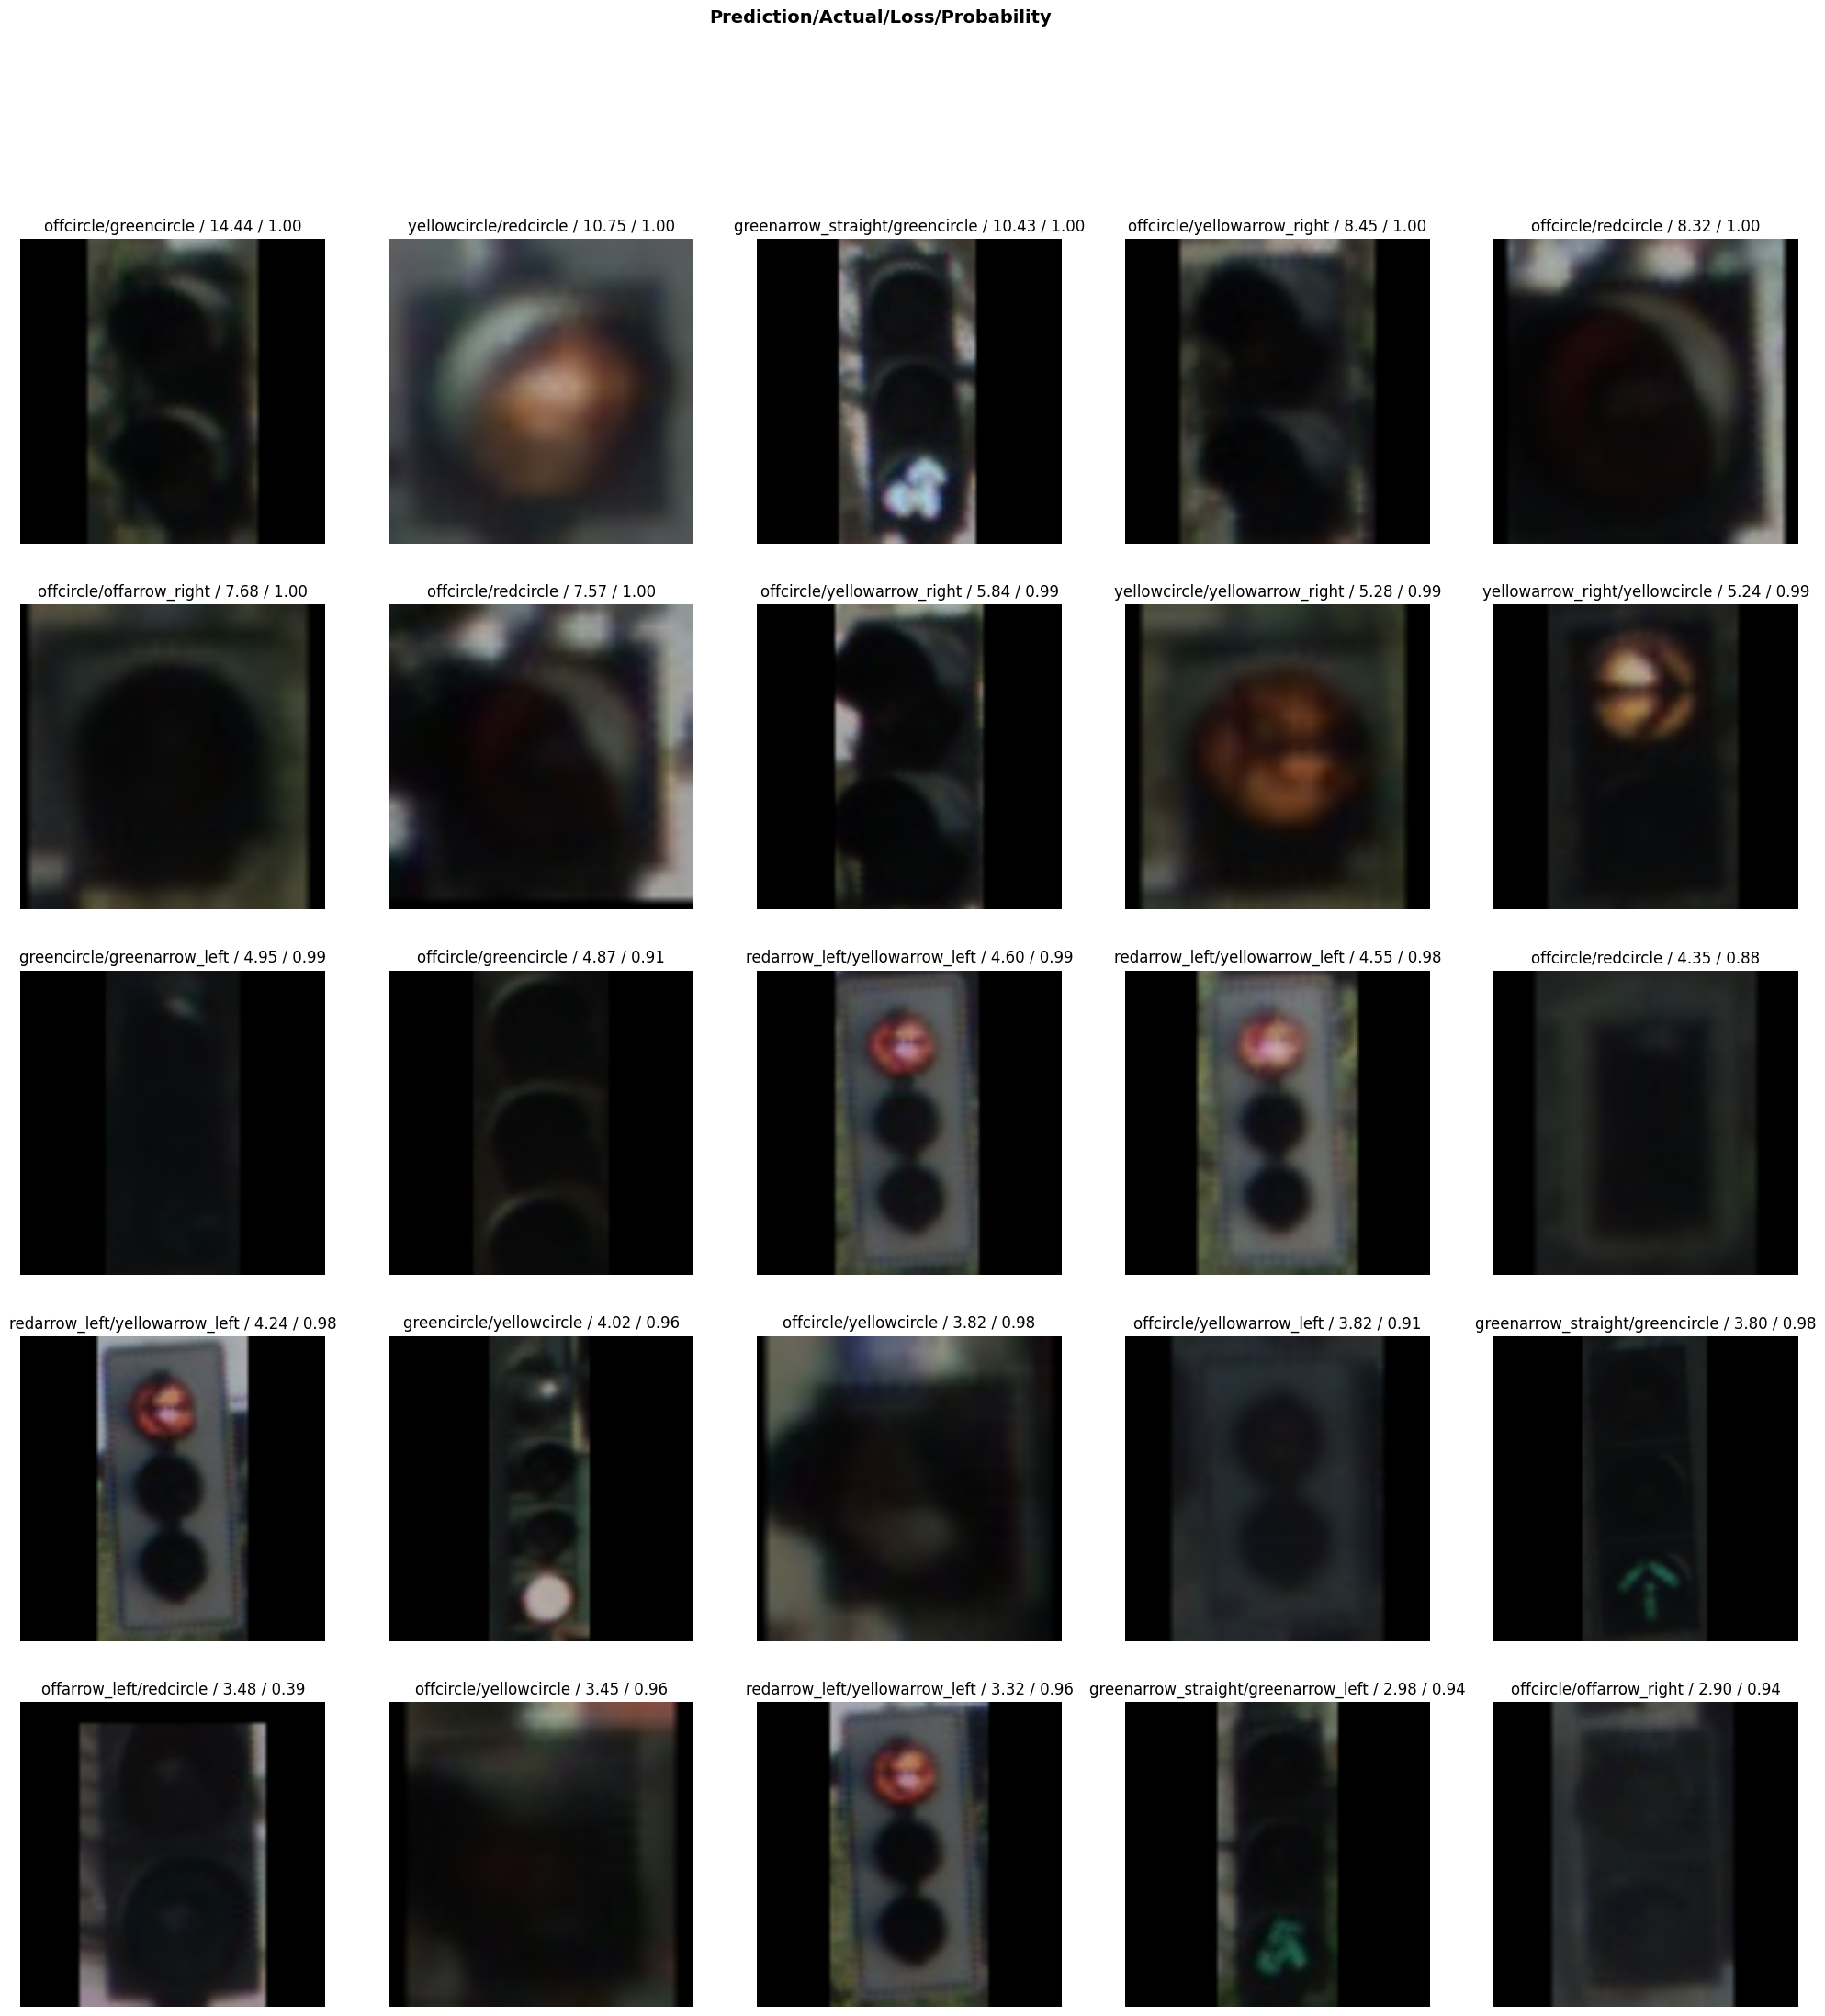

In [33]:
interp.plot_top_losses(25, figsize=(25, 25))

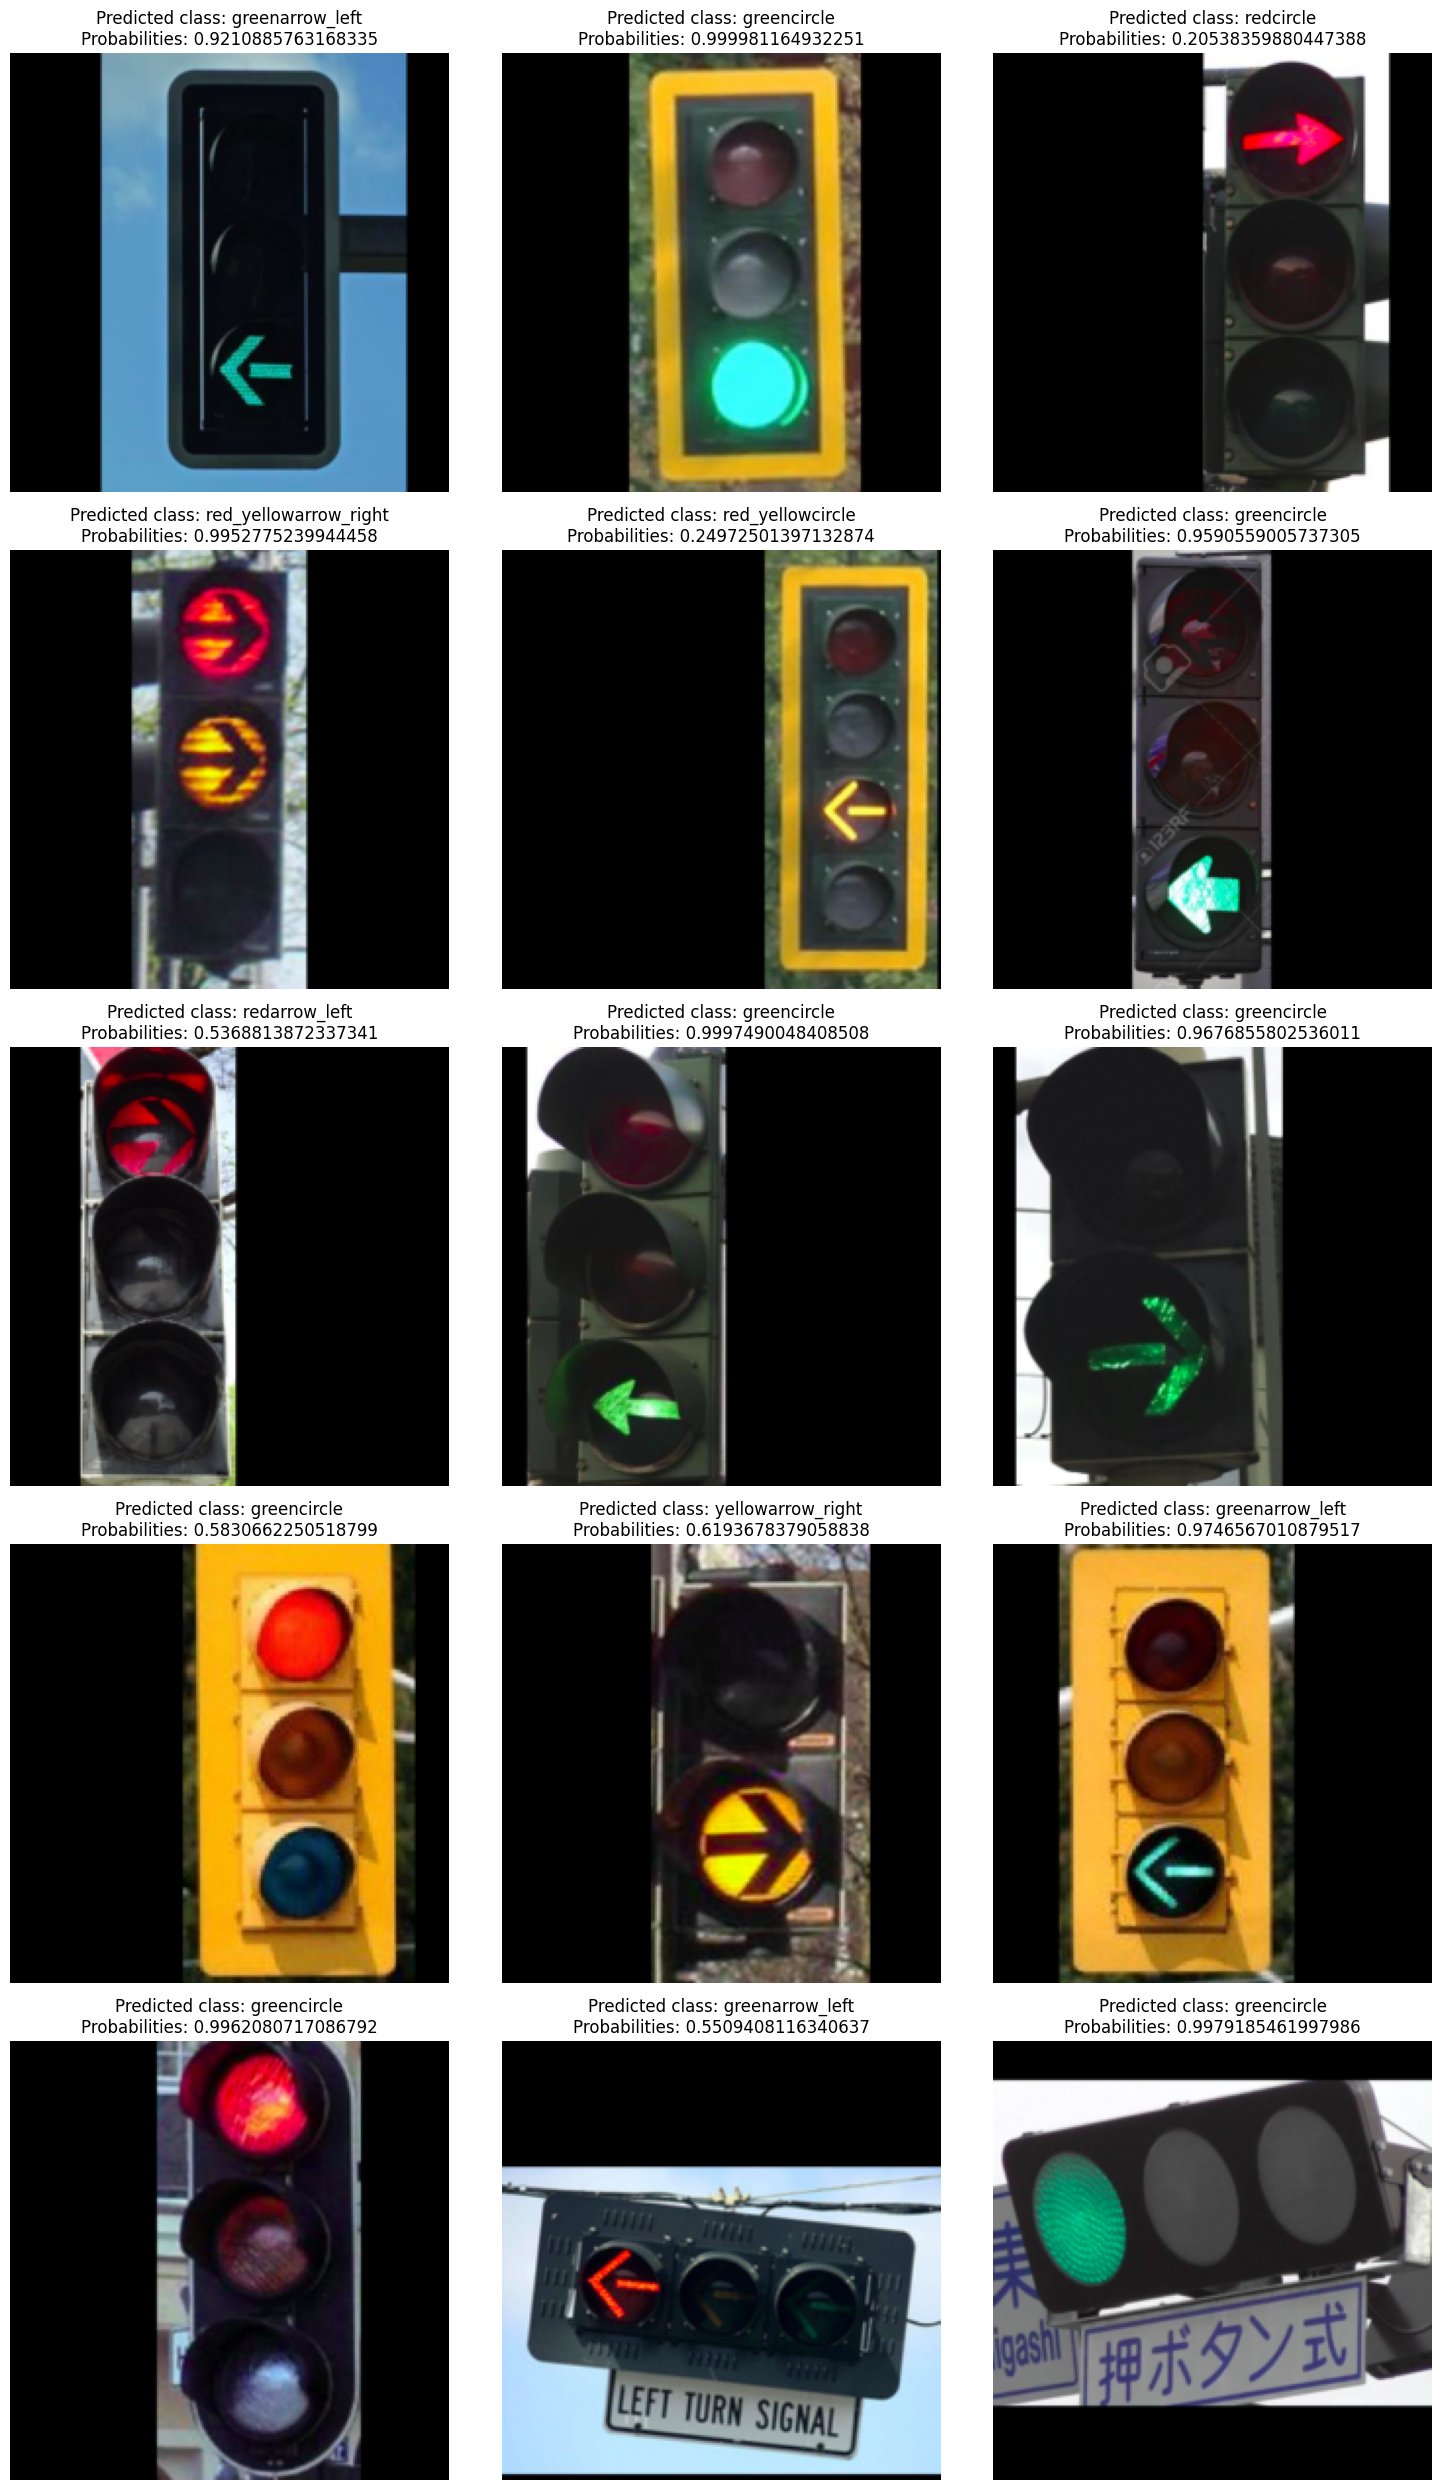

In [34]:
import matplotlib.pyplot as plt

folder_path = "/home/ippen/personal/traffic-light-classification/datasets/samples"

# Get a list of all image files in the folder
image_files = get_image_files(folder_path)

# Define the cropping transformation
crop_transform = Resize(224, ResizeMethod.Pad, pad_mode='zeros')

# Calculate the number of rows and columns for the subplot grid
num_images = len(image_files)
num_cols = 3  # Number of columns in the grid
num_rows = (num_images - 1) // num_cols + 1  # Number of rows in the grid

# Create the subplot grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

# Iterate over the image files and make predictions
for idx, image_file in enumerate(image_files):
    img = PILImage.create(image_file)
    
    # Apply the cropping transformation to the image
    cropped_img = crop_transform(img)

    # Use the learner to predict the cropped image
    prediction = learn.predict(cropped_img)

    # Access the predicted class and associated probabilities
    predicted_class = prediction[0]
    probabilities = prediction[2]

    # Plot the image and display the predicted class and probabilities
    ax = axs[idx // num_cols, idx % num_cols]
    ax.imshow(cropped_img)
    ax.axis('off')
    ax.set_title(f"Predicted class: {predicted_class}\nProbabilities: {max(probabilities)}")

# Adjust the spacing between subplots and display the plot
plt.tight_layout()
plt.show()

### Results
- Decent first results, but sometimes fatal errors on new images.
- The naive way of completely independent classes should be addressed in the next version by adding Multi-Target classes 